We have SVI scores for census tracts. We want them for neighborhoods.

This notebook calculates the area-and-population-weighted average SVI for neighborhoods.

#### Step 0: Step up
Import the library:

In [1]:
import geopandas as gpd
from shapely.validation import explain_validity
from matplotlib import pyplot as plt

Address a Conda <--> Proj errror

In [2]:
# Source: https://gis.stackexchange.com/questions/364421/how-to-make-proj-work-via-anaconda-in-google-colab
import os; os.environ['PROJ_LIB'] = '/path/to/env/share/proj'

Load census tract and neighborhood files

In [3]:
c=gpd.read_file("data/Los_Angeles_County_CVA_Social_Vulnerability_Index.geojson").to_crs(epsg=6933)
n=gpd.read_file("data/neighborhood.geojson").to_crs(epsg=6933)

#### Step 1: Drop neighborhoods with geometry problems (nested shells)

Two neighborhoods have "nested shells" in their geometry, throwing errors when calculating the intersection later.

Construct a list of neighborhoods from the geodataframe

In [4]:
hoods = []
for i in list(range(0,n.shape[0])):
    hoods.append([n.iloc[i]])

Construct a list of shape validity (with indices matching the neighborhood list)

In [5]:
# Code inspired by: https://gis.stackexchange.com/questions/413670/turn-a-multipolygon-with-nested-shells-into-a-polygon-with-holes?rq=1
valid_geo=[explain_validity(hood[0]["geometry"])=='Valid Geometry' for hood in hoods]

Construct a new geodataframe with only neighborhoods with valid geometry

In [6]:
n["valid"]=valid_geo
m=n[n["valid"]==True]

#### Step 2: Calculate the area-averaged population and population x SVI of each neighborhood

Convert neighborhoods and tracts to lists

In [7]:
hoods = []
for i in list(range(0,m.shape[0])):
    hoods.append([m.iloc[i]])

In [8]:
tracts = []
for i in list(range(0,c.shape[0])):
    tracts.append([c.iloc[i]])

Define aggregation functions

In [9]:
def f1(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f2(b,aa):
    return sum([f1(a,b)*a[0]["SoVI_Score"]*a[0]["Population"] for a in aa])
def f3(aa,bb):
    return [f2(b,aa)/b[0]["geometry"].area for b in bb]

In [10]:
def f4(a,b):
    return (a[0]["geometry"].intersection(b[0]["geometry"])).area
def f5(b,aa):
    return sum([f4(a,b)*a[0]["Population"] for a in aa])
def f6(aa,bb):
    return [f5(b,aa)/b[0]["geometry"].area for b in bb]

Use functinos 1-3 to calculate the area-averaged population x SVI of each neighborhood

In [11]:
x=f3(tracts,hoods)

/opt/conda/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Use functinos 4-5 to calculate the area-averaged population of each neighborhood

In [12]:
y=f6(tracts,hoods)

Divide these lists to find the area-and-population-averaged SVI for each neighborhood

In [13]:
ratios = []
for i in list(range(0,m.shape[0])):
    ratios.append(x[i]/y[i])

Assign these values to the neighborhoods geodataframe

In [14]:
m["mean_SVI"]=ratios

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### Plot tract and neighborhood SVI

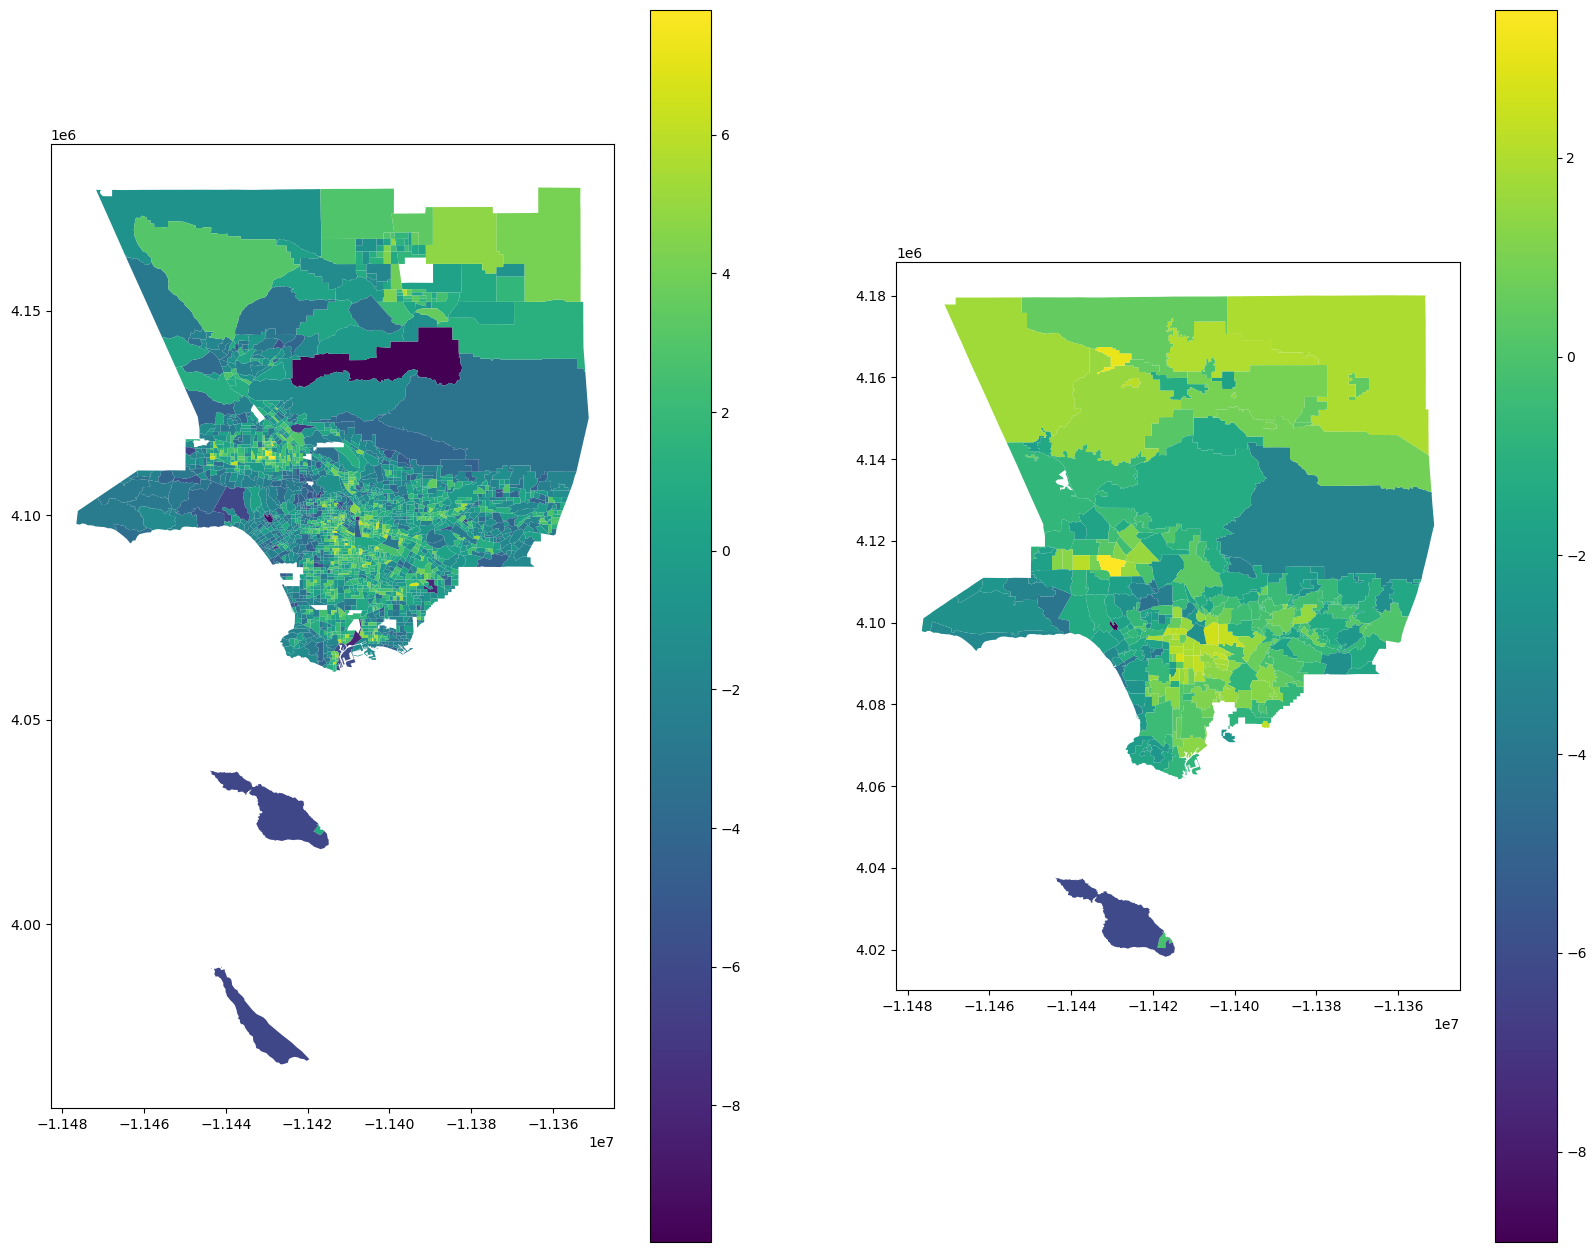

In [15]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
ax1 = c.plot(ax=ax1, column='SoVI_Score', legend=True)
ax2 = m.plot(ax=ax2, column='mean_SVI', legend=True)